#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Сервис хотел бы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. 

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Задачи:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Обучение-модели-линейной-регрессии" data-toc-modified-id="Обучение-модели-линейной-регрессии-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Обучение модели линейной регрессии</a></span></li><li><span><a href="#Обучение-модели-случайного-леса" data-toc-modified-id="Обучение-модели-случайного-леса-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Обучение модели случайного леса</a></span></li><li><span><a href="#Обучение-модели-градиентного-бустинга" data-toc-modified-id="Обучение-модели-градиентного-бустинга-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Обучение модели градиентного бустинга</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

## Подготовка

In [1]:
# Блок с импортами.
!pip install -U scikit-learn -q

import pandas as pd
import numpy as np
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor

In [2]:
# Зададим константы.
RANDOM_STATE = 4221
TEST_SIZE = 0.1

In [3]:
# Загружаем данные.
taxi = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
taxi.head(20)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


In [4]:
# Взглянем на распределение даты.
taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


В исходном датасете представлена информация о количестве заказов, поступивших в период за каждые десять минут с 1-го марта 2018-го года по 31-ое августа 2018-го года.

In [5]:
# Проверим данные на монотонность.
taxi.index.is_monotonic_increasing

True

In [6]:
# Нам нужны значения за каждый час, соответственно произведём ресэмплирование.
taxi = taxi.resample('1H').sum()
taxi.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


**Итоги изучения и подготовки данных:**

- В исходном датасете представлена информация о количестве заказов, поступивших в период за каждые десять минут с 1-го марта 2018-го года по 31-ое августа 2018-го года.
- На этапе подготовки провели ресэмплирование данных по одному часу.

## Анализ

Декомпозируем датасет и изучим тренд и сезонность данных.

In [7]:
decomposed = seasonal_decompose(taxi)

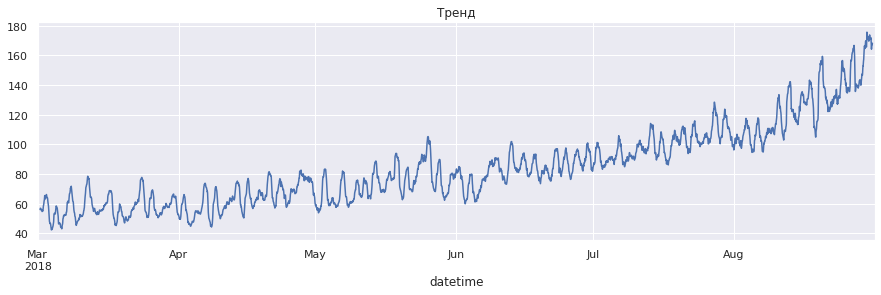

In [8]:
sns.set(rc={'figure.figsize': (15, 4)})

plt.title('Тренд')
decomposed.trend.plot();

Налюдаем, что за изучаемый период среднее число заказов плавно увеличивается. <font color='green'> В начале августа тренд имеет небольшое ускорение.
</font>

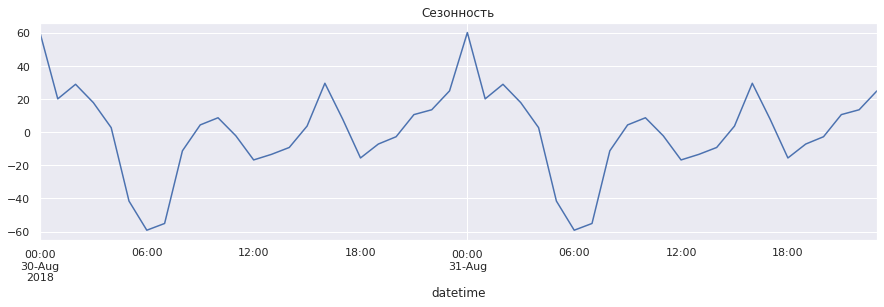

In [9]:
plt.title('Сезонность суточная')
decomposed.seasonal.tail(48).plot();

Наблюдаем три пика активности пользователей: в 10:00, в 16:00 и в 00:00. Меньше всего заказов в 6:00.

<font color='green'>
    
- 5:00-7:00 — наименее загруженное время дня;
- 7:00-11:00 — количество заказов резко увеличивается, достигая первого пика в 10:00;
- 11:00-14:00 — умеренно нагруженное время;
- 14:00-17:00 — количество заказов вновь увеличивается, пик к 16:00 больше первого;
- 17:00-20:00 — умеренно нагруженное время;
- 20:00-4:00 — очередной всплеск активности клиентов, период с 23:00 до 1:00 — самое загруженное время дня.
    
</font>

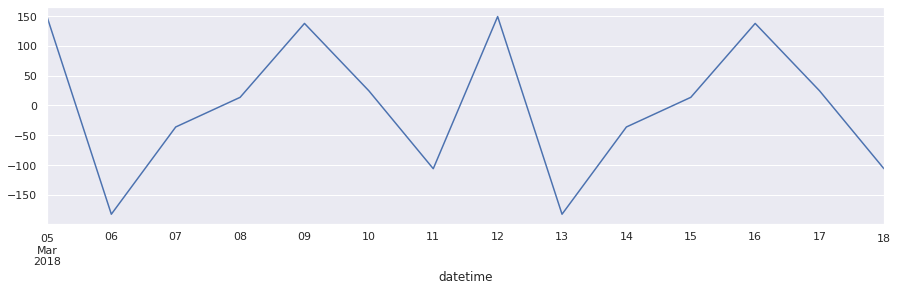

In [10]:
taxi_day_resampled = taxi.resample('1D').sum()
decomposed_dr = seasonal_decompose(taxi_day_resampled)

plt.title('Сезонность недельная')
decomposed_dr.seasonal['2018-03-05':'2018-03-18'].plot();

<font color='green'>

Сезонность за неделю:

- Понедельник и пятница — самые загруженные дни.
- Среда, четверг и суббота умеренно загруженны.
- Во вторник и воскресенье число заказов чаще снижено.
    </font>

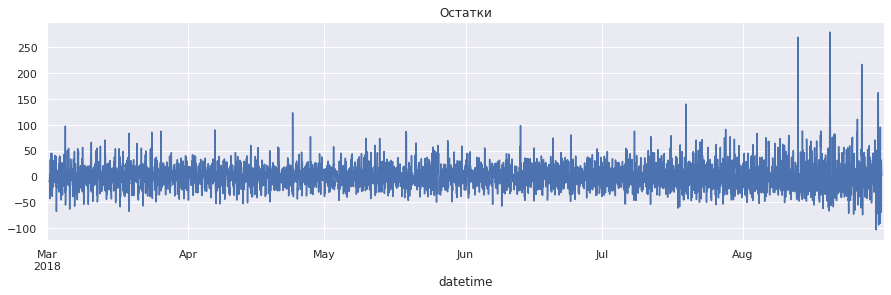

In [11]:
plt.title('Остатки')
decomposed.resid.plot();

<font color='green'> В конце графика наблюдаем более сильные шумы, следует ожидать, что разница между метриками качества при обучении модели и тестировании будет более значительной.
</font>

## Обучение

In [12]:
# Функция для добавления признаков.
def make_features(data, max_lag, rolling_mean_size):
    df = data.copy(deep=True)
    #df['month'] = df.index.month
    #df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    df['hour'] = df.index.hour
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()
    df.dropna(inplace=True)
    
    return df

# Собираем датасет для обучения.
taxi_ml = make_features(taxi, 168, 100)

In [13]:
# Разделим датасет на тренировочную и тестовую выборки.
X = taxi_ml.drop('num_orders', axis=1)
y = taxi_ml['num_orders']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    shuffle = False,
    test_size = TEST_SIZE,
    #random_state = RANDOM_STATE
)

### Обучение модели линейной регрессии

In [14]:
model = LinearRegression()

params = {}

tscv = TimeSeriesSplit(n_splits=5)

linear_model = RandomizedSearchCV(
    model,
    params,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    n_iter=5,
    cv=tscv,
    verbose=5,
    random_state=RANDOM_STATE,
)

linear_model.fit(X_train, y_train)

cv_rmse_linear = (-1) * linear_model.best_score_

linear_model.best_estimator_.fit(X_train, y_train)
linear_train_time = linear_model.cv_results_['mean_fit_time'][linear_model.best_index_]
linear_pred_time = linear_model.cv_results_['mean_score_time'][linear_model.best_index_]

#print('Лучшая модель: \n', linear_model.best_estimator_)
print('RMSE на кросс-валидации:', cv_rmse_linear)
print('Среднее время обучения модели:', linear_train_time, 'cекунд')
print('Среднее время предсказания модели:', linear_pred_time, 'cекунд')

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 1 is smaller than n_iter=5. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END ................................., score=-20.298 total time=   0.2s
[CV 2/5] END ................................., score=-20.974 total time=   0.4s
[CV 3/5] END ................................., score=-21.726 total time=   0.4s
[CV 4/5] END ................................., score=-22.350 total time=   0.3s
[CV 5/5] END ................................., score=-28.101 total time=   0.4s
RMSE на кросс-валидации: 22.689579657996596
Среднее время обучения модели: 0.24289941787719727 cекунд
Среднее время предсказания модели: 0.10069928169250489 cекунд


### Обучение модели случайного леса

In [15]:
random_forest_model = RandomForestRegressor(random_state=RANDOM_STATE)

random_forest_params = {
    'n_estimators': range(50, 150, 10),
    'max_depth': range(5, 30, 5)
}

rf_model = RandomizedSearchCV(
    random_forest_model,
    random_forest_params,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    n_iter=10,
    cv=tscv,
    verbose=5,
    random_state=RANDOM_STATE,
)

rf_model.fit(X_train, y_train)

cv_rmse_rf = (-1) * rf_model.best_score_

rf_model.best_estimator_.fit(X_train, y_train)
rf_train_time = rf_model.cv_results_['mean_fit_time'][linear_model.best_index_]
rf_pred_time = rf_model.cv_results_['mean_score_time'][linear_model.best_index_]

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END ..max_depth=25, n_estimators=130;, score=-20.288 total time=   7.1s
[CV 2/5] END ..max_depth=25, n_estimators=130;, score=-21.579 total time=  15.2s
[CV 3/5] END ..max_depth=25, n_estimators=130;, score=-22.040 total time=  23.7s
[CV 4/5] END ..max_depth=25, n_estimators=130;, score=-21.646 total time=  32.9s
[CV 5/5] END ..max_depth=25, n_estimators=130;, score=-29.772 total time=  42.3s
[CV 1/5] END ...max_depth=15, n_estimators=60;, score=-20.517 total time=   3.2s
[CV 2/5] END ...max_depth=15, n_estimators=60;, score=-21.688 total time=   6.7s
[CV 3/5] END ...max_depth=15, n_estimators=60;, score=-22.043 total time=  10.5s
[CV 4/5] END ...max_depth=15, n_estimators=60;, score=-21.961 total time=  14.3s
[CV 5/5] END ...max_depth=15, n_estimators=60;, score=-29.665 total time=  18.2s
[CV 1/5] END ...max_depth=10, n_estimators=60;, score=-20.377 total time=   2.8s
[CV 2/5] END ...max_depth=10, n_estimators=60;, 

In [16]:
print('Лучшая модель: \n', rf_model.best_estimator_)
print('RMSE на кросс-валидации:', cv_rmse_rf)
print('Среднее время обучения модели:', rf_train_time, 'cекунд')
print('Среднее время предсказания модели:', rf_pred_time, 'cекунд')

Лучшая модель: 
 RandomForestRegressor(max_depth=25, n_estimators=140, random_state=4221)
RMSE на кросс-валидации: 23.06455533733281
Среднее время обучения модели: 24.20455813407898 cекунд
Среднее время предсказания модели: 0.03363804817199707 cекунд


### Обучение модели градиентного бустинга

In [17]:
catboost = CatBoostRegressor(random_state=RANDOM_STATE, verbose=False)

params = {}

catboost_model = RandomizedSearchCV(
    catboost,
    params,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    n_iter=5,
    cv=tscv,
    verbose=5,
    random_state=RANDOM_STATE,
)

catboost_model.fit(X_train, y_train)

cv_rmse_catboost = (-1) * catboost_model.best_score_

catboost_model.best_estimator_.fit(X_train, y_train)
catboost_train_time = catboost_model.cv_results_['mean_fit_time'][catboost_model.best_index_]
catboost_pred_time = catboost_model.cv_results_['mean_score_time'][catboost_model.best_index_]

print('RMSE на кросс-валидации:', cv_rmse_catboost)
print('Среднее время обучения модели:', catboost_train_time, 'cекунд')
print('Среднее время предсказания модели:', catboost_pred_time, 'cекунд')

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 1 is smaller than n_iter=5. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[CV 1/5] END ................................., score=-19.798 total time=  22.6s
[CV 2/5] END ................................., score=-20.613 total time=  25.5s
[CV 3/5] END ................................., score=-21.617 total time=  29.6s
[CV 4/5] END ................................., score=-21.449 total time=  32.2s
[CV 5/5] END ................................., score=-29.766 total time=  34.0s
RMSE на кросс-валидации: 22.64847131233382
Среднее время обучения модели: 28.780407190322876 cекунд
Среднее время предсказания модели: 0.01009068489074707 cекунд


Соберём вместе результаты обучения моделей.

In [18]:
results = {
    'model': ['LinearRegression', 'RandomForest', 'CatBoost'],
    'train_time (seconds)': [linear_train_time, rf_train_time, catboost_train_time],
    'pred_time (seconds)': [linear_pred_time, rf_pred_time, catboost_pred_time],
    'cv_rmse': [cv_rmse_linear, cv_rmse_rf, cv_rmse_catboost]
}

models = pd.DataFrame(results)
models

,model,train_time (seconds),pred_time (seconds),cv_rmse
0,LinearRegression,0.242899,0.100699,22.689580
1,RandomForest,24.204558,0.033638,23.064555
2,CatBoost,28.780407,0.010091,22.648471


Итак, все модели преодолели порог по качеству (rmse <= 48). Качество на кросс-валидации модели градиентного бустинга и модели линейной регрессии различается незначительно, однако вторая обучается намного быстрее. 

## Тестирование

Выведем метрику качества на тестовой выборке модели линейной регрессии.

In [21]:
# Добавим проверку на адекватность.
pred_previous = y_test.shift()
pred_previous.iloc[0] = y_train.iloc[-1]
print('RMSE:', (mean_squared_error(y_test, pred_previous)) ** 0.5)

RMSE: 58.819724582830204


In [20]:
predictions = linear_model.predict(X_test)
print('RMSE лучшей модели на тестовой выборке:', (mean_squared_error(y_test, predictions)) ** 0.5)

RMSE лучшей модели на тестовой выборке: 34.25980525349294


## Общий вывод

Компанией «Чётенькое такси» поставлена задача: построить модель МО для создания прогнозов количества заказов такси на следующий час.

Для решения задачи выполнены следующие шаги:

**1 Подготовки данных**

**Итоги изучения и подготовки данных:**

- В исходном датасете представлена информация о количестве заказов, поступивших в период за каждые десять минут с 1-го марта 2018-го года по 31-ое августа 2018-го года.
- На этапе подготовки провели ресэмплирование данных по одному часу.

**2 Анализ данных**

Анализ показал, что:

- За изучаемый период времени среднее число заказов плавно увеличивалось. <font color='green'> В начале августа тренд имеет небольшое ускорение.
- В течение дня можно фиксировать три пика активности пользователей сервиса: в 10:00, в 16:00 и в 00:00. Меньше всего заказов в 6:00.
    <font color='green'>
    
  - 5:00-7:00 — наименее загруженное время дня;
  - 7:00-11:00 — количество заказов резко увеличивается, достигая первого пика в 10:00;
  - 11:00-14:00 — умеренно нагруженное время;
  - 14:00-17:00 — количество заказов вновь увеличивается, пик к 16:00 больше первого;
  - 17:00-20:00 — умеренно нагруженное время;
  - 20:00-4:00 — очередной всплеск активности клиентов, период с 23:00 до 1:00 — самое загруженное время дня.
  - Понедельник и пятница — самые загруженные дни.
  - Среда, четверг и суббота умеренно загруженны.
  - Во вторник и воскресенье число заказов чаще снижено.
- Анализ остатков показал сильные шумы в конце графика. Следует ожидать, что разница между метриками качества при обучении модели и тестировании будет более значительной.
        
</font>

**3 Обучение моделей**

**Итоги обучения модели линейной регрессии:**

- RMSE на кросс-валидации: 22.689579657996596
- Среднее время обучения модели: 0.24289941787719727 cекунд
- Среднее время предсказания модели: 0.10069928169250489 cекунд

**Итоги обучения модели RandomForest:**

- RMSE на кросс-валидации: 23.06455533733281
- Среднее время обучения модели: 24.20455813407898 cекунд
- Среднее время предсказания модели: 0.03363804817199707 cекунд

**Итоги обучения модели CatBoost:**

- RMSE на кросс-валидации: 22.64847131233382
- Среднее время обучения модели: 28.780407190322876 cекунд
- Среднее время предсказания модели: 0.01009068489074707 cекунд

**4 Тестирование лучшей модели**

Все модели преодолели порог по качеству на кросс-валидации (rmse <= 48). <font color='green'>Качество на кросс-валидации модели градиентного бустинга и модели линейной регрессии различается незначительно, однако вторая обучается намного быстрее.</font>



<font color='green'>
    
RMSE модели линейной регрессии на тестовой выборке: 34.25980525349294</font>